# Data Analysis Example

In this notebook we use the example provided in "Graph and Data Analysis Example" and work out some of the questions using Python. 

## Problem 

A space observatory measures the speed $v$ with which a number of satellites are moving in their orbit together with their distance from Earth's center $r$. The complete set of results is given in the table below.

![image.png](figures/satellites_table.png)

Newton's laws of gravitation indicates that the velocity is related to the distance from the Earth's center through the equation:

$$ v^2= \frac{\frac{4}{3}\pi G\rho_ER^3_E}{r} $$

where $G$ is the Universal Gravitational constant while $R_E$ and $\rho_E$ are respectively the radius and density of Earth. In an effort to determine a value for $G$, the following measurements were also taken

![image.png](figures/density_table.png)

The above measuremet were saved in an [Excel workbook](data_analysis_example.xlsx).

Use this information to answer the following questions:
1. Determine the average and std values for the Earth's radius and density
2. Calculate the corresponding values for $r^{-1}$ and $v^2$
3. Plot a graph of $r^{-1}$ against $v^2$
4. Determine the gradient and the intercept of this graph

Please refer to the Graph and Data Analysis example for a discussion on how to interpret the tables above.

 ## Solution
 
The answers for (1) can be obtained by using a calculator, however this is labour intensive so we'll be using Python to do so. First order of business is to load the contents of the Excel file. We'll be using [Pandas](pandas.ipynb) to do so. 
 
Let's import all the required packages first

In [3]:
from matplotlib import pyplot as plt
from math import sqrt
import pandas as pd
import numpy as np

# Enable inline plotting
%matplotlib inline

 #### 0. Load Excel sheet

In [4]:
# Read the first worksheet
satellite_speed = pd.read_excel('data_analysis_example.xlsx', 0)
satellite_speed

,r / km,±1,8426,10152,12309,15227,21036,29241,40676,71002
0,v / 104 km hr-1,0.001,2.34,2.232,1.987,1.763,1.653,1.432,1.136,0.923


Note that the above statement loads the data as well as the row titles (the leftmost two columns). Since this is not part of our data we do not need to load them. We will use the `iloc` property of a DataFrame to specify which rows and columns we want to keep:

In [5]:
satellite_speed.iloc[:, 2:]

,8426,10152,12309,15227,21036,29241,40676,71002
0,2.34,2.232,1.987,1.763,1.653,1.432,1.136,0.923


Notice also that the data frame interprets the first row as column headers, while in fact the data does not contain column headers. We can tell Pandas to not interpret the first row as header when reading the file as follows:

In [6]:
# Read the first worksheet, specifying that there is no header row
satellite_speed = pd.read_excel('data_analysis_example.xlsx', 0, header=None)
satellite_speed = satellite_speed.iloc[:, 2:]

satellite_speed

,2,3,4,5,6,7,8,9
0,8426.00,10152.000,12309.000,15227.000,21036.000,29241.000,40676.000,71002.000
1,2.34,2.232,1.987,1.763,1.653,1.432,1.136,0.923


This looks much better. Let's load the second worksheet as well

In [7]:
density_radius = pd.read_excel('data_analysis_example.xlsx', 1, header=None)
density_radius = density_radius.iloc[:, 2:]
density_radius

,2,3,4,5,6
0,5520,5495,5630,5523,5540
1,6378,6362,6390,6383,6369


Let us seperate the rows from both tables so that we can work with 1D arrays.

In [8]:
satellite_radius = satellite_speed.iloc[0, :] 
satellite_velocity =  satellite_speed.iloc[1, :]
earth_density = density_radius.iloc[0, :]
earth_radius = density_radius.iloc[1, :]

satellite_velocity

2    2.340
3    2.232
4    1.987
5    1.763
6    1.653
7    1.432
8    1.136
9    0.923
Name: 1, dtype: float64

#### 1. Average, standard deviation and uncertainty of  density and radius

To compute the average of the radius and density from the second table we can simply use the `mean` function applied on the dataframe.

In [9]:
earth_density_average = earth_density.mean()
earth_radius_average = earth_radius.mean()

print("Average density is {:.3f}, average radius is {:.3f}".format(earth_density_average, earth_radius_average))

Average density is 5541.600, average radius is 6376.400


We can use the same technique to calculate the standard deviation, this time using the `std` function:

In [10]:
earth_density_std = earth_density.std()
earth_radius_std = earth_radius.std()

print("Std density is {:.3f}, std radius is {:.3f}".format(earth_density_std, earth_radius_std))

Std density is 51.964, std radius is 11.104


At this point we can compute the uncertainty of this calculation:

$$ \Delta \overline{X} = t_{\alpha,n-1} \frac{s}{\sqrt{n}}$$

In this case $n$=5 so that $t_{\alpha,n-1}$=2.78. We can now calculate the uncertainty in the density and radius:

In [11]:
from math import sqrt

t = 2.78
earth_delta_density = 2.78 * earth_density_std / sqrt(5)
earth_delta_radius = 2.78 * earth_radius_std / sqrt(5)

print("Delta density is {:.3f}, delta radius is {:.3f}".format(earth_delta_density, earth_delta_radius))

Delta density is 64.605, delta radius is 13.805


#### 2. Calculate values for $r^{-1}$ and $v^2$

$r^{-1}$ is the inverse of the radius whilst $v^2$ is the square of the velocity. We can use Pandas to compute them. Note that the initial unit in velocity is 10<sup>4</sup> km h<sup>-1</sup> whilst we want to unit of the velocity squared in 10<sup>5</sup> m<sup>2</sup> s<sup>-1</sup>, so an appropriate conversion is required:

In [12]:
radius_inverse = 1.0 / satellite_radius
velocity_squared = (satellite_velocity * 1e3 * (1/3600.0) * 1e4) ** 2 * 1e-5

#### 3. Plot $v^2$ versus $r^{-1}$

We will use matplotlib to plot these values. We want the units of y-axis to be 10<sup>5</sup> m<sup>2</sup> s<sup>-1</sup> whilst those of the x-axis 10<sup>-9</sup> m, therefore we'll need to scale the inverse radius.

We also want to plot the trendline (perform a linear regression on the data). To get the trendline we'll use the polynomial fitting function of `numpy`. This requires two steps:
1. Calculate the polynomial coefficients required to generate the trendline. In our case, since we know that the data is linear, one coefficients (which would be the gradient) is enough
2. Evaluate the polynomial across the required x-axis range

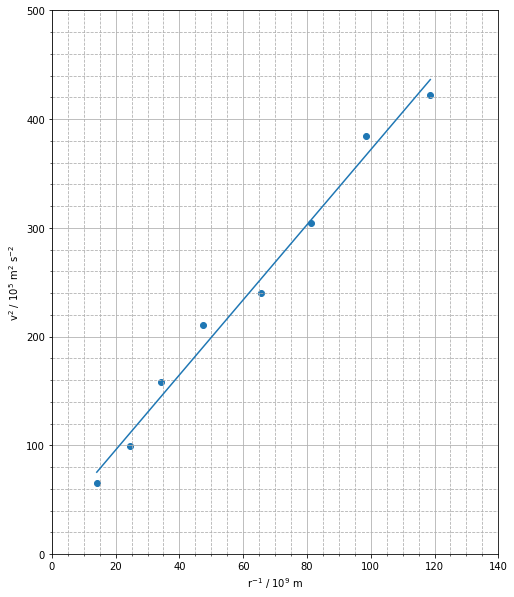

In [17]:
scaled_radius_inverse = radius_inverse * 1e6

# Create figure and set size
f = plt.figure(figsize=(8, 10))

# Generate the scatter plot
plt.scatter(scaled_radius_inverse, velocity_squared)

# Show x and y label (you can use latex here)
plt.xlabel(r'r$^{-1}$ / 10$^9$ m')
plt.ylabel(r'v$^2$ / 10$^5$ m$^2$ s$^{-2}$')

# Set x and y limits
plt.xlim([0, 140])
plt.ylim([0, 500])

# Enable minor ticks so that we can show a fine grid
plt.minorticks_on()
plt.grid(b=True, which='major', linestyle='-')
plt.grid(b=True, which='minor', linestyle='--')

# Calculate the polynomical coefficients (last parameters is the number of coefficients)
coeffs = np.polyfit(scaled_radius_inverse, velocity_squared, 1)

# Generate the polynomial function, which when called will take a list of x-values
# and will return the respective y values
poly_function = np.poly1d(coeffs)

# Generate trendline
trendline = poly_function(scaled_radius_inverse)

# Add trendline to plot
plt.plot(scaled_radius_inverse, trendline)

To save your figure as an image file, you can use the statement below:

In [14]:
plt.savefig("my_plot.png", dpi=300)

<Figure size 432x288 with 0 Axes>

#### 4. Obtain gradient and intercept

Now that we have generated the trendline we can compute it's gradient and intercept. Remember that to compute the trendline we have fitted a 1D polynomial to the data. A 1D polynomial of the form $y=mx + c$ has 2 coefficients, $m$ and $c$, which automatically give us the required values. However, we are also interested in the *error* of these values. We can tell `polyfit` to return the residuals (covariance matrix) of the fit, which we can then use to calculate the error:

In [15]:
# Run polyfit again, this time telling it to return the covariance matrix
coeffs, V = np.polyfit(scaled_radius_inverse, velocity_squared, 1, cov=True)
gradient = coeffs[0]
intercept = coeffs[1]

# Compute the gradient and intercept error
gradient_error = np.sqrt(V[0][0])
intercept_error = np.sqrt(V[1][1])

# Aside: If you also want the correlation coefficient, you can:
correlation = np.corrcoef(scaled_radius_inverse, velocity_squared)[0, 1]

print("Gradient is {:.3f}, with error {:.3f}".format(gradient, gradient_error))
print("Intercept is {:.3f}, with error {:.3f}".format(intercept, intercept_error))
print("Correlation coefficient is {:.3f}".format(correlation))

Gradient is 3.452, with error 0.199
Intercept is 26.637, with error 13.859
Correlation coefficient is 0.993


Note that the original units remain valid for the above values